# Enzyme analysis

1. Convert the enzyme variant to amino acids based on the AAs and be warned about 1 vs 0 so need to check
2. Calculate concentration rather than yield (if yield is given then yield * mmol concentration)
3. Normalize to parent for each column (TTN, Yield)
4. Embeddings sequences
5. Convert to LevSeq format

In [1]:
! export CUDA_VISIBLE_DEVICES=1

In [67]:
import pandas as pd
import os
import torch 

# CUDA setup
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

data_dir = 'output'
files = os.listdir('LLM-extended-YL-manual/')
all_dfs = pd.DataFrame()
for f in files:
    if '.csv' in f:
        df = pd.read_csv(f'LLM-extended-YL-manual/{f}')
        df['paper'] = f
        all_dfs = pd.concat([all_dfs, df])
df = all_dfs
df

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,selectivity_raw,cofactor,reaction_condition,campaign_id,generation,parent_enzyme_id,additional_information,paper,conversion,activity
0,NCR,1.0,Plate_1,A01,CN1C[C@](C)(Cc2ccccc2)CC1=O,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C >> C(C1=CC=C...,1.0,1.0,NaN,NaN,...,90:10 er,NaN,reaction_temperature:25°C;reaction_ph:7.0;reac...,NCR_beta_lactam_application,0.0,NaN,"{""x_axis_label"":""NCR"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN
1,NCR-D294W-Y343W,1.0,Plate_1,A02,CN1C[C@](C)(Cc2ccccc2)CC1=O,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C >> C(C1=CC=C...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,99:1 er,NaN,reaction_temperature:25°C;reaction_ph:7.0;reac...,NCR_beta_lactam_application,1.0,NCR,"{""x_axis_label"":""NCR-Y343W-D294W"",""conversion""...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN
2,NCR-D294W-Y343W,1.0,Plate_1,A03,COc1ccc(C[C@]2(C)CC(=O)N(C)C2)cc1,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C >> COC1=CC=C...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NaN,NaN,reaction_temperature:nan;reaction_ph:nan;react...,NCR_beta_lactam_application,NaN,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN
3,NCR-D294W-Y343W,1.0,Plate_1,A04,CN1C[C@](C)(Cc2ccc(Br)cc2)CC1=O,BrC1=CC=C(C=C1)/C=C(/CN(C(CCl)=O)C)\C >> BrC1=...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NaN,NaN,reaction_temperature:nan;reaction_ph:nan;react...,NCR_beta_lactam_application,NaN,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN
4,NCR-D294W-Y343W,1.0,Plate_1,A05,Cc1ccc(C[C@]2(C)CC(=O)N(C)C2)cc1,ClCC(=O)N(C\C(=C\C1=CC=C(C=C1)C)\C)C >> CN1C(C...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NaN,NaN,reaction_temperature:nan;reaction_ph:nan;react...,NCR_beta_lactam_application,NaN,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,wtNMT,1.0,Plate_1,G06,Cc1c(-c2ccccc2)cnn1C,Cc1n[nH]cc1c2ccccc2 >> Cn1ncc(c2ccccc2)c1C,1.0,1.0,NaN,NaN,...,NaN,NaN,reaction_temperature:nan;reaction_ph:nan;react...,NMT_FuncLib_Pyrazole_Alkylation,NaN,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN
78,v22,1.0,Plate_1,G07,Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2 >> Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,D167H_D197A_S201A_Y213H_Y247M_N249C,...,NaN,NaN,reaction_temperature:nan;reaction_ph:nan;react...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN
79,v22,1.0,Plate_1,G08,Cc1c(-c2ccccc2)cnn1C,Cc1n[nH]cc1c2ccccc2 >> Cn1ncc(c2ccccc2)c1C,1.0,1.0,NaN,D167H_D197A_S201A_Y213H_Y247M_N249C,...,NaN,NaN,reaction_temperature:nan;reaction_ph:nan;react...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN
80,v49,1.0,Plate_1,G09,Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2 >> Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,D167C_D197A_S201C_Y242H_Y247W_N249A,...,NaN,NaN,reaction_temperature:nan;reaction_ph:nan;react...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN


In [68]:
parents = df.drop_duplicates(subset='paper', keep='first')
parents['smiles_reaction'] = [s.replace(' ', '') for s in parents['smiles_reaction'].values]

/tmp/ipykernel_2735199/263272828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parents['smiles_reaction'] = [s.replace(' ', '') for s in parents['smiles_reaction'].values]


In [69]:
parents = df.drop_duplicates(subset='paper', keep='first')
parents['smiles_reaction'] = [s.replace(' ', '') for s in parents['smiles_reaction'].values]
other_parents = pd.read_csv('output/parents_LLM_extraction_annot.csv')

#parents.to_csv('output/parents_LLM_extraction.csv', index=False)

/tmp/ipykernel_2735199/4252717048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parents['smiles_reaction'] = [s.replace(' ', '') for s in parents['smiles_reaction'].values]


In [70]:
parents['idx'] = [f'{r}_{p}' for r, p in parents[['smiles_string', 'aa_sequence']].values]
other_parents['idx'] = [f'{r}_{p}' for r, p in other_parents[['smiles_string', 'aa_sequence']].values]
parents = parents[~parents['idx'].isin(set(other_parents['idx'].values))]
parents

/tmp/ipykernel_2735199/183052680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parents['idx'] = [f'{r}_{p}' for r, p in parents[['smiles_string', 'aa_sequence']].values]


,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,cofactor,reaction_condition,campaign_id,generation,parent_enzyme_id,additional_information,paper,conversion,activity,idx
0,NCR,1.0,Plate_1,A01,CN1C[C@](C)(Cc2ccccc2)CC1=O,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>C(C1=CC=CC=...,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:25°C;reaction_ph:7.0;reac...,NCR_beta_lactam_application,0.0,NaN,"{""x_axis_label"":""NCR"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,CN1C[C@](C)(Cc2ccccc2)CC1=O_MPSLFDPIRFGAFTAKNR...
0,RA95.5-8,1.0,Plate_1,A01,CCOC(=O)/C(C#N)=C/C=C/c1ccc(N(C)C)cc1,CN(C1=CC=C(C=O)C=C1)C.C(#N)CC(=O)OCC>>C(#N)/C(...,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:29 °C;reaction_ph:7.5;rea...,Knoevenagel_Condensation_RA95.5-8_to_KN.4,0.0,NaN,"{""x_axis_label"":""RA95.5-8"",""conversion"":""nan"",...",Fast Knoevenagel Condensations Catalyzed by an...,NaN,NaN,CCOC(=O)/C(C#N)=C/C=C/c1ccc(N(C)C)cc1_MPRYLKGW...
0,Pf2B9,1.0,Plate_1,A01,N[C@@H](Cc1c[nH]c2cccc([N+](=O)[O-])c12)C(=O)O,[N+](=O)([O-])C1=C2C=CNC2=CC=C1.N[C@H](C(=O)O)...,1.0,1.0,NaN,I16V_E17G_I68V_F95L_T292S_F274S_T321A_V384A,...,NaN,reaction_temperature:75 °C;reaction_ph:8.0;rea...,TrpB_4NitroTrp_Evolution,0.0,NaN,"{""x_axis_label"":""Pf2B9"",""catalyst_form"":""heat-...",Unlocking Reactivity of TrpB A General Biocata...,NaN,NaN,N[C@@H](Cc1c[nH]c2cccc([N+](=O)[O-])c12)C(=O)O...
0,WT TmCHMO,1.0,Plate_1,A01,CC(=O)OCCc1ccccc1.COC(=O)CCc1ccccc1,C1(=CC=CC=C1)CCC(C)=O>>C(C)(=O)OCCC1=CC=CC=C1....,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:30°C;reaction_ph:7.4;reac...,TmCHMO_Ketone1_Regioselectivity,0.0,NaN,"{""x_axis_label"":""WT"",""conversion"":""100.0"",""cat...",Overriding Traditional Electronic Effects in B...,NaN,NaN,CC(=O)OCCc1ccccc1.COC(=O)CCc1ccccc1_MSTTQTPDLD...
0,Wildtype Rma cyt c,1.0,Plate_1,A01,COc1ccc(C(O)CN)cc1,CC(C)(C)C(=O)ON.O[S](=O)(=O)C(F)(F)F.COc1ccc(C...,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:room temperature;reaction...,Rma_cytochrome_c_aminohydroxylation,0.0,NaN,"{""x_axis_label"":""Rma cytochrome c"",""catalyst_f...",dna-Enantioselective Aminohydroxylation of Sty...,NaN,NaN,COc1ccc(C(O)CN)cc1_TESGTAAQDPEALAAEIGPVKQVSLGE...
0,WT Mb,1.0,Plate_1,A01,CCOC(=O)/C=C/c1ccccc1,O=Cc1ccccc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)/C=C/...,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:room temperature;reaction...,Myoglobin_AldehydeOlefination_VariantCharacter...,0.0,NaN,"{""x_axis_label"":""WT Mb"",""catalyst_form"":""purif...",Myoglobin-Catalyzed Olefination of Aldehydes_f...,NaN,NaN,CCOC(=O)/C=C/c1ccccc1_VLSEGEWQLVLHVWAKVEADVAGH...
0,WT Mb,1.0,Plate_1,A01,O=C1OC[C@H]2[C@@H]1[C@@H]2c1ccccc1,[N+](=[N-])=CC(=O)OCC=CC1=CC=CC=C1>>C1(=CC=CC=...,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:room temperature;reaction...,Mb_Stereodivergent_Cyclopropanation_Evolution,0.0,NaN,"{""x_axis_label"":""WT"",""catalyst_form"":""purified...",Stereodivergent Intramolecular Cyclopropanatio...,NaN,NaN,O=C1OC[C@H]2[C@@H]1[C@@H]2c1ccccc1_VLSEGEWQLVL...
0,WT CoMb,1.0,Plate_1,A01,C=O,O=C=O>>C=O,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:no more than 28 °C;reacti...,CoMb_SCS_Rational_Design,0.0,NaN,"{""x_axis_label"":""WT CoMb"",""notes"":""Data extrac...",Engineering an Oxygen-Binding Protein for Phot...,NaN,NaN,C=O_MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLE...
0,P-4 A82L,1.0,Plate_1,A01,CCOC(=O)CC(OC)c1ccc(OC)cc1,COC1=CC=C(C=C1)COC.[N+](=[N-])=CC(=O)OCC>>COC(...,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:room temperature;reaction...,P411_CHF_CH_Alkylation,0.0,NaN,"{""x_axis_label"":""1"",""catalyst_form"":""clarified...",Enzymatic assembly of carbon-carbon bonds via ...,NaN,NaN,CCOC(=O)CC(OC)c1ccc(OC)cc1_MTIKEMPQPKTFGELKNLP...
0,Mb,1.0,Plate_1,A01,CCOC(=O)[C@@H]1C[C@H]1c1ccccc1.CCOC(=O)[C@H]1C...,C=CC1=CC=CC=C1.[N+](=[N-])=CC(=O)OCC>>C1(=CC=C...,1.0,1.0,NaN,NaN,...,NaN,reaction_temperature:room temperature;reaction...,myoglobin_cyclopropanation_mutagenesis,0.

In [71]:
other_parents

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,campaign_id,generation,parent_enzyme_id,additional_information,paper,conversion,activity,intermediate,substrate,idx
0,chai0,1,Plate_1,A01,CCOC(=O)CC=Cc1ccc(OC)cc1.CCOC(=O)CCCc1ccc(OC)cc1,COc1ccc(C=C)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,1,1.0,NaN,NaN,...,CarH_Mutant_Screening,0.0,NaN,"{""x_axis_label"":""Parent CarH*"",""notes"":""X-axis...",dna-Controlling Non-Native Cobalamin Reactivit...,NaN,NaN,CCOC(=O)C=[N+]=[N-],COc1ccc(C=C)cc1,CCOC(=O)CC=Cc1ccc(OC)cc1.CCOC(=O)CCCc1ccc(OC)c...
1,chai1,1,Plate_1,A01,C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1,1.0,NaN,NaN,...,hCAII_active_site_mutant_characterization,0.0,NaN,"{""x_axis_label"":""wt-hCAII (0.05 mol%)"",""cataly...",dna-Abiotic reduction of ketones with silanes ...,NaN,NaN,C1(=CC=CC=C1)[SiH3],C1(=CC=CC=C1)C(C)=O,C[C@H](O)c1ccccc1_MKSSHHHHHHENLYFQSNAMSHHWGYGK...
2,chai2,1,Plate_1,A01,CCC(O)C(C)=O,O=C(C(=O)[O-])C.[Na+].C(CC)=O>>OC(C(C)=O)CC,1,1.0,NaN,NaN,...,TK_Pyruvate_Aldehyde_Evolution,0.0,NaN,"{""x_axis_label"":""4M"",""catalyst_form"":""purified...",dna-Engineering transketolase to accept both u...,NaN,NaN,[Na+].C(CC)=O,O=C(C(=O)[O-])C,CCC(O)C(C)=O_MSSRKELANAIRALSMDAVQKAKSGHPGAPMGM...
3,chai3,1,Plate_1,B08,N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O,>>N[C@@H](CC1=CC(I)=C(C(I)=C1)OC1=CC(I)=C(C=C1...,1,1.0,A361G_A362C_A363T,K121A,...,Sav_Scaffold_Optimization_Screen,1.0,22 C Sav WT,"{""x_axis_label"":""A"",""conversion"":""nan"",""cataly...",A cell-penetrating artificial metalloenzyme re...,NaN,NaN,NaN,NaN,N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)...
4,chai4,1,Plate_1,A01,CCOC(=O)C1C2Oc3ccccc3C21,O1C=CC2=C1C=CC=C2.[N+](=[N-])=CC(=O)OCC>>C1(C2...,1,1.0,NaN,NaN,...,Mb_Benzofuran_Cyclopropanation_Engineering,0.0,NaN,"{""x_axis_label"":""Mb"",""catalyst_form"":""purified...",Biocatalytic Strategy for Highly Diastereo- an...,NaN,NaN,[N+](=[N-])=CC(=O)OCC,O1C=CC2=C1C=CC=C2,CCOC(=O)C1C2Oc3ccccc3C21_VLSEGEWQLVLHVWAKVEADV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,chai70,1,Plate_1,A01,O=C1CCCCC1C(C[N+](=O)[O-])c1ccccc1,C1(CCCCC1)=O.[N+](=O)([O-])/C=C/C1=CC=CC=C1>>[...,1,1.0,NaN,NaN,...,LmrR_Michael_Addition_Evolution,0.0,NaN,"{""x_axis_label"":""LmrR_L57C_THP"",""catalyst_form...",Design and Evolution of an Enzyme for the Asym...,NaN,NaN,[N+](=O)([O-])/C=C/C1=CC=CC=C1,C1(CCCCC1)=O,O=C1CCCCC1C(C[N+](=O)[O-])c1ccccc1_GAEIPKEMLRA...
71,chai71,1,Plate_1,A01,CCOC(=O)C(C)[Si](C)(C)c1ccccc1,CCOC(=O)C(C)=[N+]=[N-].C[SiH](C)c1ccccc1>>CCOC...,1,1.0,NaN,NaN,...,Rma_TDE_CarbeneTransferase_Characterization,1.0,Rma cyt c WT,"{""x_axis_label"":""Rma TDE"",""notes"":""TTN value o...",Catalytic iron-carbene intermediate revealed i...,NaN,NaN,C[SiH](C)c1ccccc1,CCOC(=O)C(C)=[N+]=[N-],CCOC(=O)C(C)[Si](C)(C)c1ccccc1_MKYLLPTAAAGLLLL...
72,chai72,1,Plate_1,A01,COc1ccc(C(CC(C)=O)C[N+](=O)[O-])cc1,COC1=CC=C(C=C1)\C=C\[N+](=O)[O-].CC(C)=O>>COC1...,1,1.0,NaN,T53L_K210H,...,default_characterization,1.0,RA95.5-8,"{""x_axis_label"":""T53L/K210H"",""catalyst_form"":""...",dna-Enantiocomplementary Synthesis of γ-Nitrok...,NaN,NaN,CC(C)=O,COC1=CC=C(C=C1)\C=C\[N+](=O)[O-],COc1ccc(C(CC(C)=O)C[N+](=O)[O-])cc1_MPRYLKGWLE...
73,chai73,1,Plate_1,A01,CCOC(=O)[C@H](C)N(C)c1ccccc1,CNc1ccccc1.CCOC(=O)C(C)=[N+]=[N-]>>CCOC(=O)[C@...,1,1.0,NaN,NaN,...,IrCYP119_NH_insertion_evolution,0.0,NaN,"{""x_axis_label"":""155F,213G,254L,317G (CNH-0)"",...",dna-Directed Evolution of Artificial Metalloen...,NaN,NaN,CCOC(=O)C(C)=[N+]=[N-],CNc1ccccc1,CCOC(=O)[C@H](C)N(C)c1ccccc1_MYDWFSEMRKKDPVYYD...


In [72]:
parents['intermediate'] = ['.'.join(s.split('>>')[0].split('.')[1:]) for s in parents['smiles_reaction'].values]
parents['substrate'] = [s.split('>>')[0].split('.')[0] for s in parents['smiles_reaction'].values]
parents['id'] = [f'chai{75 + i}' for i in range(0, len(parents))]
parents.to_csv('output/parents_LLM_extraction_v2.csv')

# Iterate through the parent amino acid sequence and make the variant sequence 

Since sometimes people use 0 index and sometimes 1 index, first check the parent AA sequnece has the correct AA on the LHS.

In [73]:
from sciutil import SciUtil

u = SciUtil()

def convert_to_variant(parent, aa_to_change, verbose=False):
    warn = []
    error = []
    variant = []
    #try:
    aa_to_change = aa_to_change.replace(' ', '').strip()
    variant = list(parent)
    parent = list(parent)
    sep = '_'
    # check what separator was used
    if '_' in aa_to_change:
        sep = '_'
    elif ',' in aa_to_change:
        sep = ','
    for aa in aa_to_change.split(sep):
        if 'FAD' not in aa:
            aa = aa.split('+')[0] # Remove any random domains... 
            try:
                parent_aa = aa[0]
                variant_aa = aa[-1]
                position = int(aa[1:-1])
                # Check the parent at the position is correct
                if position < len(parent):
                    if parent[position] == variant_aa and parent[position - 1] == variant_aa : # Can't distinguish... since they are the same!
                        if verbose:
                            u.warn_p(['Defaulting to 1 index since could not distinguish... warning to check sequence'])
                        variant[position + 1] = variant_aa
                        warn.append([aa, 'Warning: position 0 and 1 index had same AA used 1 index'])
                    elif parent[position] == variant_aa: # 0 index
                        variant[position] = variant_aa
                    elif parent[position - 1] == variant_aa: # 1 index
                        variant[position - 1] = variant_aa
                    else:
                        error.append([aa, 'Error in parent AA != AA in seq']) # Failed at this one we have an idea about where it was
                elif parent[position - 1] == variant_aa: # 1 index
                        variant[position - 1] = variant_aa
                else:
                    error.append([aa, 'Error in parent AA != AA in seq']) # Failed at this one we have an idea about where it was
            except Exception as e:
                error.append([aa, str(e)])
        else:
            u.warn_p(['FAD domain, manually check'])

    return ''.join(variant), warn, error
    
# Check these are the same since this is what we need
assert convert_to_variant('MTKKEMPQPKTFGELKNLPLLNTD', 'A2K')[0] == 'MTKKEMPQPKTFGELKNLPLLNTD' # 0 indexed example
assert convert_to_variant('MKTKEMPQPKTFGELKNLPLLNTD', 'A2K')[0] == 'MKTKEMPQPKTFGELKNLPLLNTD' # 1 indexed
assert len(convert_to_variant('MAAKEMPQPKTFGELKNLPLLNTD', 'A2K')[2]) > 0 # Should print an error too 

In [28]:
convert_to_variant('MAAKEMPQPKTFGELKNLPLLNTD', 'A2K')

('MAAKEMPQPKTFGELKNLPLLNTD', [], [['A2K', 'Error in parent AA != AA in seq']])

In [76]:
df = df.dropna(subset=['smiles_reaction'])
df['smiles_reaction'] = [s.replace(' ', '') for s in df['smiles_reaction'].values]
df['amino_acid_substitutions'].fillna('#PARENT#', inplace=True)

/tmp/ipykernel_2735199/3460560035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smiles_reaction'] = [s.replace(' ', '') for s in df['smiles_reaction'].values]
/tmp/ipykernel_2735199/3460560035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amino_acid_substitutions'].fillna('#PARENT#', inplace=True)


In [77]:
from tqdm import tqdm 
from Bio.Seq import translate
import re

aas = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

reg = f"^[{''.join(aas)}]*$"

parent_aa = []
variant_aa = []
errors, warnings = [], []
changed = 0

for parent, aa_to_change in tqdm(df[['aa_sequence', 'amino_acid_substitutions']].values):
    if not parent or not isinstance(parent, str) or len(parent) < 2:
        # Try converting the parent nt
        parent = None
        errors.append(['Parent was not string?'])
        warnings.append(['Parent was not string?'])
        parent_aa.append(None)
        continue
        parent_nt = parent_nt.replace(' ', '')
        parent = translate(parent_nt)
    parent = parent.replace(' ', '')
    parent = parent.strip()
    # We're replace his tags... 
    parent = parent.replace('LEHHHHHH', '').replace('HHHHHH', '').replace('*', '')
    # Check if the parent has any odd AAs
    if not re.match(reg, parent):
        # Parent has strange seqs..
        for ai, a in enumerate(parent):
            if a not in aas:
                print(a, ai)
        errors.append(['Parent had a non-correct AA in it.. check for numbers!'])
        variant_aa.append(None)
        warnings.append(None)
        parent_aa.append(parent)
        continue
    aa_to_change = aa_to_change.strip()
    if aa_to_change != '#PARENT#' and parent is not None:
        variant, warn, err = convert_to_variant(parent, aa_to_change)
        # Check if it got truncated 
        variant = variant.split('*')[0] # Truncate 
        variant_aa.append(variant)
        # Ensure the variant only has amino acids
        if not re.match(reg, variant):
            # Parent has strange seqs..
            print('NO MATCH')
            break
        changed += 1
        if variant_aa == parent:
            print('Same?', aa_to_change)
        if len(warn) == 0: 
            warnings.append(None)
        else:
            warnings.append(warn)
        if len(err) == 0:
            errors.append(None)
        else:
            errors.append(err)
    else:
        variant_aa.append(None)
        errors.append(None)
        warnings.append(None)
    parent_aa.append(parent)


100%|█████████████████████████████████████████| 2557/2557 [00:00<00:00, 46134.87it/s]

B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
B 172
O 125
O 125
O 125
O 125
O 125
O 125
O 125


In [78]:
errors

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 [['L198F', 'Error in parent AA != AA in seq']],
 [['V121I', 'Error in parent AA != AA in seq'],
  ['V143L', 'Error in parent AA != AA in seq'],
  ['L198K', 'Error in parent AA != AA in seq']],
 [['V121L', 'Error in parent AA != AA in seq'],
  ['V143L', 'Error in parent AA != AA in seq'],
  ['L198V', 'Error in parent AA != AA in seq']],
 [['V121I', 'Error in parent AA != AA in seq'],
  ['V143L', 'Error in parent AA != AA in seq'],
  ['L198F', 'Error in parent AA != AA in seq'],
  ['W209K', 'Error in parent AA != AA in seq']],
 [['V121I', 'Error in parent AA != AA in seq'],
  ['L198F', 'Error in parent AA != AA in seq'],
  ['W209K', 'Error in parent AA != AA in seq']],
 [['V121I', 'Error in parent AA != AA in seq'],
  ['L198V', 'Error in parent AA != AA in seq']],
 [['L198K', 'Error in p

In [79]:
df['parent_aa'] = parent_aa
df['errors'] = errors
df['warnings'] = warnings
# Print out the number of errors
err_df = df[~df['errors'].isna()]
err_df

/tmp/ipykernel_2735199/1684868513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parent_aa'] = parent_aa
/tmp/ipykernel_2735199/1684868513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['errors'] = errors
/tmp/ipykernel_2735199/1684868513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,campaign_id,generation,parent_enzyme_id,additional_information,paper,conversion,activity,parent_aa,errors,warnings
1,mutant 1 VFFW,1.0,Plate_1,A02,C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1.0,1.0,NaN,V143F_L198F,...,hCAII_active_site_mutant_characterization,1.0,hCAII,"{""x_axis_label"":""1"",""catalyst_form"":""whole cel...",dna-Abiotic reduction of ketones with silanes ...,NaN,NaN,MKSSENLYFQSNAMSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDI...,"[[L198F, Error in parent AA != AA in seq]]",None
2,mutant 10 ILKW,1.0,Plate_1,A03,C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1.0,1.0,NaN,V121I_V143L_L198K,...,hCAII_active_site_mutant_characterization,1.0,hCAII,"{""x_axis_label"":""10"",""catalyst_form"":""whole ce...",dna-Abiotic reduction of ketones with silanes ...,NaN,NaN,MKSSENLYFQSNAMSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDI...,"[[V121I, Error in parent AA != AA in seq], [V1...",None
3,mutant 2 LLVW,1.0,Plate_1,A04,C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1.0,1.0,NaN,V121L_V143L_L198V,...,hCAII_active_site_mutant_characterization,1.0,hCAII,"{""x_axis_label"":""2"",""catalyst_form"":""whole cel...",dna-Abiotic reduction of ketones with silanes ...,NaN,NaN,MKSSENLYFQSNAMSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDI...,"[[V121L, Error in parent AA != AA in seq], [V1...",None
4,mutant 3 ILFK,1.0,Plate_1,A05,C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1.0,1.0,NaN,V121I_V143L_L198F_W209K,...,hCAII_active_site_mutant_characterization,1.0,hCAII,"{""x_axis_label"":""3"",""catalyst_form"":""whole cel...",dna-Abiotic reduction of ketones with silanes ...,NaN,NaN,MKSSENLYFQSNAMSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDI...,"[[V121I, Error in parent AA != AA in seq], [V1...",None
5,mutant 4 IFFK,1.0,Plate_1,A06,C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1.0,1.0,NaN,V121I_V143F_L198F_W209K,...,hCAII_active_site_mutant_characterization,1.0,hCAII,"{""x_axis_label"":""4"",""catalyst_form"":""whole cel...",dna-Abiotic reduction of ketones with silanes ...,NaN,NaN,MKSSENLYFQSNAMSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDI...,"[[V121I, Error in parent AA != AA in seq], [L1...",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,v49,1.0,Plate_1,F07,Cn1ccc(C2CC2)n1,C1CC1c2cc[nH]n2>>Cn1ccc(n1)C2CC2,1.0,1.0,NaN,D167C_D197A_S201C_Y242H_Y247W_N249A,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,"[[Y242H, Error in parent AA != AA in seq], [Y2...",None
67,v49,1.0,Plate_1,F08,Cn1nccc1C1CC1,C1CC1c2cc[nH]n2>>Cn1nccc1C2CC2,1.0,1.0,NaN,D167C_D197A_S201C_Y242H_Y247W_N249A,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,"[[Y242H, Error in parent AA != AA in seq], [Y2...",None
75,v49,1.0,Plate_1,G04,Cn1ccc(-c2ccccc2F)n1,Fc1ccccc1c2cc[nH]n2>>Cn1ccc(n1)c2ccccc2F,1.0,1.0,NaN,D167C_D197A_S201C_Y242H_Y247W_N249A,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,"[[Y242H, Error in parent AA != AA in seq], [Y2...",None
80,v49,1.0,Plate_1,G09,Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2>>Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,D167C_D197A_S201C_Y242H_Y247W_N249A,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,"[[Y242H, Error in parent AA != AA in seq], [Y2...",None


In [80]:
df = df[df['errors'].isna()]
df

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,campaign_id,generation,parent_enzyme_id,additional_information,paper,conversion,activity,parent_aa,errors,warnings
0,NCR,1.0,Plate_1,A01,CN1C[C@](C)(Cc2ccccc2)CC1=O,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>C(C1=CC=CC=...,1.0,1.0,NaN,#PARENT#,...,NCR_beta_lactam_application,0.0,NaN,"{""x_axis_label"":""NCR"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None
1,NCR-D294W-Y343W,1.0,Plate_1,A02,CN1C[C@](C)(Cc2ccccc2)CC1=O,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>C(C1=CC=CC=...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR_beta_lactam_application,1.0,NCR,"{""x_axis_label"":""NCR-Y343W-D294W"",""conversion""...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None
2,NCR-D294W-Y343W,1.0,Plate_1,A03,COc1ccc(C[C@]2(C)CC(=O)N(C)C2)cc1,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>COC1=CC=C(C...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR_beta_lactam_application,NaN,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None
3,NCR-D294W-Y343W,1.0,Plate_1,A04,CN1C[C@](C)(Cc2ccc(Br)cc2)CC1=O,BrC1=CC=C(C=C1)/C=C(/CN(C(CCl)=O)C)\C>>BrC1=CC...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR_beta_lactam_application,NaN,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None
4,NCR-D294W-Y343W,1.0,Plate_1,A05,Cc1ccc(C[C@]2(C)CC(=O)N(C)C2)cc1,ClCC(=O)N(C\C(=C\C1=CC=C(C=C1)C)\C)C>>CN1C(C[C...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR_beta_lactam_application,NaN,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,v28,1.0,Plate_1,G03,Cn1nccc1-c1ccccc1F,Fc1ccccc1c2cc[nH]n2>>Cn1nccc1c2ccccc2F,1.0,1.0,NaN,D167H_D197A_S201C_Y213M_N249A,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None
76,wtNMT,1.0,Plate_1,G05,Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2>>Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,#PARENT#,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None
77,wtNMT,1.0,Plate_1,G06,Cc1c(-c2ccccc2)cnn1C,Cc1n[nH]cc1c2ccccc2>>Cn1ncc(c2ccccc2)c1C,1.0,1.0,NaN,#PARENT#,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None
78,v22,1.0,Plate_1,G07,Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2>>Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,D167H_D197A_S201A_Y213H_Y247M_N249C,...,NMT_FuncLib_Pyrazole_Alkylation,NaN,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None


# Continue with data that has no errors

Ensure that the required libraries are installed:

Install `enzyme-tk`


In [8]:
#! pip install enzymetk

In [35]:
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
import pubchempy
from tqdm import tqdm
# smiles_to_features = defaultdict(dict) # Name and canonical smiles

names = []
smiles_to_features = None
unable_to_convert = []
if not smiles_to_features:
    smiles_to_features = defaultdict(dict)
ms = []
for rxn in tqdm(set(df['smiles_reaction'].values)):
    try:
        rxn = rxn.strip() # Remove any spaces 
        # Also replace any double '//' with single ones
        rxn = rxn.replace(r'C)\\C', r'C)\C')
        rxn = rxn.replace('[N2]CC#N', 'N#CC=[N+]=[N-]')
        for c in rxn.replace('>>', '.').split('.'):
            if not smiles_to_features.get(c):
                try:
                    canonical_smiles = Chem.CanonSmiles(c)
                    mol = Chem.MolFromSmiles(canonical_smiles)
                    if mol is not None:
                        ms.append(mol)
                        compounds = pubchempy.get_compounds(canonical_smiles, namespace='smiles')
                        smiles_to_features[c]['name'] = compounds[0].iupac_name
                        smiles_to_features[c]['cannonical_smiles'] = canonical_smiles
                        name = compounds[0].iupac_name
                        if name != None:
                            names.append(name)
                        else:
                            names.append(c)
                    else:
                        unable_to_convert.append(rxn)
                except:
                    unable_to_convert.append(rxn)
                    break
    except:
        unable_to_convert.append(rxn)
        print(rxn)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 795/795 [05:15<00:00,  2.52it/s]


In [81]:
cannonical_reactions = []
names = []
errors = []
errs = 0
reaction_names = []
for rxn in tqdm(df['smiles_reaction'].values):
    cannonical_substrates, cannonical_products = [], []
    rxn = rxn.strip() # Remove any spaces 
    rxn = rxn.replace(r'C)\\C', r'C)\C')
    rxn = rxn.replace('[N2]CC#N', 'N#CC=[N+]=[N-]')
    err = False
    substate_names = []
    product_names = []
    for substrate in rxn.split('>>')[0].split('.'):
        substrate = smiles_to_features.get(substrate)
        if substrate:
            cannonical_substrates.append(substrate.get('cannonical_smiles'))
            substate_names.append(substrate.get('name'))
        else:
            errors.append(f'No cannonical substrate, {substrate}')
            cannonical_reactions.append(None)
            reaction_names.append(None)
            err = True
            break
    if not err:
        for product in rxn.split('>>')[1].split('.'):
            product = smiles_to_features.get(product)
            if product:
                cannonical_products.append(product.get('cannonical_smiles'))
            else:
                errors.append(f'No cannonical product, {product}')
                cannonical_reactions.append(None)
                reaction_names.append(None)
                err = True
                break
    if not err:
        cannonical_substrates.sort()
        cannonical_products.sort()
        cannonical_rxn = '.'.join(cannonical_substrates) + '>>' + '.'.join(cannonical_products)
        cannonical_reactions.append(cannonical_rxn)
        reaction_names.append(' + '.join([str(s) for s in substate_names]) + ' = ' + ' + '.join([str(p) for p in product_names]))
        errors.append(None)


100%|████████████████████████████████████████| 2449/2449 [00:00<00:00, 255575.89it/s]


In [82]:
df['smiles_string'] = cannonical_reactions
df['named_reactions'] = reaction_names
df['smiles_errors'] = errors
df.to_csv('output/protein-evolution-database_V5_LLM.csv', index=False)

In [83]:
df

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,parent_enzyme_id,additional_information,paper,conversion,activity,parent_aa,errors,warnings,named_reactions,smiles_errors
0,NCR,1.0,Plate_1,A01,None,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>C(C1=CC=CC=...,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""NCR"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None,None,"No cannonical substrate, None"
1,NCR-D294W-Y343W,1.0,Plate_1,A02,None,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>C(C1=CC=CC=...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR,"{""x_axis_label"":""NCR-Y343W-D294W"",""conversion""...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None,None,"No cannonical substrate, None"
2,NCR-D294W-Y343W,1.0,Plate_1,A03,None,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>COC1=CC=C(C...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None,None,"No cannonical substrate, None"
3,NCR-D294W-Y343W,1.0,Plate_1,A04,None,BrC1=CC=C(C=C1)/C=C(/CN(C(CCl)=O)C)\C>>BrC1=CC...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None,None,"No cannonical substrate, None"
4,NCR-D294W-Y343W,1.0,Plate_1,A05,None,ClCC(=O)N(C\C(=C\C1=CC=C(C=C1)C)\C)C>>CN1C(C[C...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NCR,"{""x_axis_label"":""nan"",""conversion"":""nan"",""cata...",Synthesis of i β i -Quaternary Lactams Using P...,NaN,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None,None,"No cannonical substrate, None"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,v28,1.0,Plate_1,G03,Fc1ccccc1-c1cc[nH]n1>>Cn1nccc1-c1ccccc1F,Fc1ccccc1c2cc[nH]n2>>Cn1nccc1c2ccccc2F,1.0,1.0,NaN,D167H_D197A_S201C_Y213M_N249A,...,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-(2-fluorophenyl)-1H-pyrazole =,None
76,wtNMT,1.0,Plate_1,G05,Cc1n[nH]cc1-c1ccccc1>>Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2>>Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-methyl-4-phenyl-1H-pyrazole =,None
77,wtNMT,1.0,Plate_1,G06,Cc1n[nH]cc1-c1ccccc1>>Cc1c(-c2ccccc2)cnn1C,Cc1n[nH]cc1c2ccccc2>>Cn1ncc(c2ccccc2)c1C,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-methyl-4-phenyl-1H-pyrazole =,None
78,v22,1.0,Plate_1,G07,Cc1n[nH]cc1-c1ccccc1>>Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2>>Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,D167H_D197A_S201A_Y213H_Y247M_N249C,...,wtNMT,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-methyl-4-phenyl-1H-pyrazole =,None


In [40]:
import pickle
with open('output/cannoical_smiles_LLM.pkl', 'wb') as file:
    pickle.dump(smiles_to_features, file)

In [84]:
rxn_df = df.drop_duplicates(subset='smiles_string')
rxn_df = rxn_df[~rxn_df['smiles_string'].isna()]
rxn_df['id'] = [f'RXN{i}' for i in range(0, len(rxn_df))]
rxn_df

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,parent_enzyme_id,additional_information,paper,conversion,activity,parent_aa,errors,warnings,named_reactions,smiles_errors
0,RXN0,1.0,Plate_1,A01,C=Cc1ccc(OC)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,COc1ccc(C=C)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""Parent CarH*"",""notes"":""X-axis...",dna-Controlling Non-Native Cobalamin Reactivit...,NaN,NaN,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,None,None,1-ethenyl-4-methoxybenzene + ethyl 2-diazoacet...,None
0,RXN1,1.0,Plate_1,A01,CC(=O)c1ccccc1.[SiH3]c1ccccc1>>C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""wt-hCAII (0.05 mol%)"",""cataly...",dna-Abiotic reduction of ketones with silanes ...,NaN,NaN,MKSSENLYFQSNAMSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDI...,None,None,1-phenylethanone + phenylsilane =,None
0,RXN2,1.0,Plate_1,A01,CC(=O)C(=O)[O-].CCC=O.[Na+]>>CCC(O)C(C)=O,O=C(C(=O)[O-])C.[Na+].C(CC)=O>>OC(C(C)=O)CC,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""4M"",""catalyst_form"":""purified...",dna-Engineering transketolase to accept both u...,NaN,NaN,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,None,None,2-oxopropanoate + sodium(1+) + propanal =,None
1,RXN3,1.0,Plate_1,A02,CC(=O)C(=O)[O-].O=CCO>>CC(=O)C(O)CO,C(CO)=O.C(C(=O)C)(=O)[O-]>>OC(C(C)=O)CO,1.0,1.0,A299T,H100L,...,4M,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""o...",dna-Engineering transketolase to accept both u...,NaN,NaN,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,None,None,2-hydroxyacetaldehyde + 2-oxopropanoate =,None
2,RXN4,1.0,Plate_1,A03,CC(=O)C(=O)[O-].CCC=O>>CCC(O)C(C)=O,C(CC)=O.C(C(=O)C)(=O)[O-]>>OC(C(C)=O)CC,1.0,1.0,A299T_T1407A_G1559A_T1560A,H100L_D469E_R520Q,...,4M/H100L/D469E,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""o...",dna-Engineering transketolase to accept both u...,NaN,NaN,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,None,"[[R520Q, Warning: position 0 and 1 index had s...",propanal + 2-oxopropanoate =,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,RXN299,1.0,Plate_1,F10,c1coc(-c2cc[nH]n2)c1>>Cn1nccc1-c1ccco1,[nH]1ccc(n1)c2occc2>>Cn1nccc1c2occc2,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-(furan-2-yl)-1H-pyrazole =,None
71,RXN300,1.0,Plate_1,F12,Fc1ccccc1-c1cc[nH]n1>>Cn1ccc(-c2ccccc2F)n1,Fc1ccccc1c2cc[nH]n2>>Cn1ccc(n1)c2ccccc2F,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-(2-fluorophenyl)-1H-pyrazole =,None
72,RXN301,1.0,Plate_1,G01,Fc1ccccc1-c1cc[nH]n1>>Cn1nccc1-c1ccccc1F,Fc1ccccc1c2cc[nH]n2>>Cn1nccc1c2ccccc2F,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-(2-fluorophenyl)-1H-pyrazole =,None
76,RXN302,1.0,Plate_1,G05,Cc1n[nH]cc1-c1ccccc1>>Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2>>Cn1cc(c2ccccc2)c(C)n1,1.0,1.0,NaN,#PARENT#,...,NaN,"{""x_axis_label"":""nan"",""catalyst_form"":""nan"",""n...",dna-Engineered Enzymes Enable Selective N-Alky...,NaN,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-methyl-4-phenyl-1H-pyrazole =,None


# Encode the reactions

In [47]:
! export CUDA_VISIBLE_DEVICES=0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')

from enzymetk.embedchem_chemberta_step import ChemBERT
from enzymetk.save_step import Save
import pandas as pd
import os

output_dir = 'tmp/'
num_threads = 1
id_col = 'id'
substrate_col = 'smiles_string'
rxn_embeddings = (rxn_df << (ChemBERT(id_col, substrate_col, num_threads) >> Save(f'output/rxn_chemberta_LLM.pkl')))


C=Cc1ccc(OC)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)CC=Cc1ccc(OC)cc1.CCOC(=O)CCCc1ccc(OC)cc1
CC(=O)c1ccccc1.[SiH3]c1ccccc1>>C[C@H](O)c1ccccc1
CC(=O)C(=O)[O-].CCC=O.[Na+]>>CCC(O)C(C)=O
CC(=O)C(=O)[O-].O=CCO>>CC(=O)C(O)CO
CC(=O)C(=O)[O-].CCC=O>>CCC(O)C(C)=O
CC(=O)C(=O)[O-].CCCCC=O>>CCC[C@H](O)C(C)=O
CC(=O)C(=O)[O-].CCCCCC=O>>CCCCCC[C@@H](O)C(C)=O
CCC(=O)C(=O)O.CCCCCC=O>>CCCCC[C@H](O)C(=O)CC
CC(=O)C(=O)[O-].O=Cc1cccc(C(=O)O)c1>>CC(=O)C(O)c1cccc(C(=O)O)c1
CCOC(=O)C=[N+]=[N-].c1ccc2occc2c1>>CCOC(=O)C1C2Oc3ccccc3C21
Cc1ccc2occc2c1>>CCOC(=O)C1C2Oc3ccc(C)cc3C21
Fc1ccc2occc2c1>>CCOC(=O)C1C2Oc3ccc(F)cc3C21
Clc1ccc2occc2c1>>CCOC(=O)C1C2Oc3ccc(Cl)cc3C21
Brc1ccc2ccoc2c1>>CCOC(=O)C1C2Oc3cccc(Br)c3C21
COc1ccc2ccoc2c1>>CCOC(=O)C1C2Oc3cccc(OC)c3C21
c1ccc2cc3occc3cc2c1>>CCOC(=O)C1C2Oc3cc4ccccc4cc3C21
C=Cc1cccc2ccoc12>>CCOC(=O)[C@H]1[C@@H]2Oc3c(cccc3[C@@H]3C[C@H]3C(=O)OCC)[C@@H]21
N#Cc1cccc2[nH]ccc12.NC(CO)C(=O)O>>N#Cc1cccc2[nH]cc(C[C@H](N)C(=O)O)c12
Brc1cccc2[nH]ccc12>>Brc1cccc2[nH]ccc12
O=[N+]([O-])c1cccc2[nH

In [86]:
rxn_embeddings_rxnfp

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,activity,parent_aa,errors,warnings,named_reactions,smiles_errors,chemberta,rxnfp,PCA1,PCA2
0,RXN0,1,Plate_1,A01,C=Cc1ccc(OC)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,COc1ccc(C=C)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,1,1.0,NaN,#PARENT#,...,NaN,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,NaN,NaN,1-ethenyl-4-methoxybenzene + ethyl 2-diazoacet...,NaN,[ 1.02921116e+00 -1.03235996e+00 -1.10792506e+...,"[-0.9962843060493469, -1.4153103828430176, 0.5...",-4.436441,-2.942849
1,RXN1,1,Plate_1,A01,CC(=O)c1ccccc1.[SiH3]c1ccccc1>>C[C@H](O)c1ccccc1,C1(=CC=CC=C1)C(C)=O.C1(=CC=CC=C1)[SiH3]>>C1(=C...,1,1.0,NaN,#PARENT#,...,NaN,MKSSENLYFQSNAMSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDI...,NaN,NaN,1-phenylethanone + phenylsilane =,NaN,[-7.62792885e-01 -6.21470571e-01 -7.28314400e-...,"[-1.5834259986877441, -2.2539169788360596, -1....",12.659476,1.802921
2,RXN2,1,Plate_1,A01,CC(=O)C(=O)[O-].CCC=O.[Na+]>>CCC(O)C(C)=O,O=C(C(=O)[O-])C.[Na+].C(CC)=O>>OC(C(C)=O)CC,1,1.0,NaN,#PARENT#,...,NaN,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,NaN,NaN,2-oxopropanoate + sodium(1+) + propanal =,NaN,[-1.03529491e-01 -1.08422267e+00 -1.02683687e+...,"[-2.8660738468170166, -1.1978602409362793, 0.0...",4.445616,10.452255
3,RXN3,1,Plate_1,A02,CC(=O)C(=O)[O-].O=CCO>>CC(=O)C(O)CO,C(CO)=O.C(C(=O)C)(=O)[O-]>>OC(C(C)=O)CO,1,1.0,A299T,H100L,...,NaN,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,NaN,NaN,2-hydroxyacetaldehyde + 2-oxopropanoate =,NaN,[-6.17657661e-01 -1.11923242e+00 -1.41747236e+...,"[-2.7752485275268555, -0.898236095905304, 0.07...",5.738901,7.287974
4,RXN4,1,Plate_1,A03,CC(=O)C(=O)[O-].CCC=O>>CCC(O)C(C)=O,C(CC)=O.C(C(=O)C)(=O)[O-]>>OC(C(C)=O)CC,1,1.0,A299T_T1407A_G1559A_T1560A,H100L_D469E_R520Q,...,NaN,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,NaN,"[['R520Q', 'Warning: position 0 and 1 index ha...",propanal + 2-oxopropanoate =,NaN,[-7.08234072e-01 -1.90729165e+00 -4.26942348e-...,"[-2.886227607727051, -1.276696801185608, 0.116...",4.680400,10.357676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,RXN295,1,Plate_1,F10,c1coc(-c2cc[nH]n2)c1>>Cn1nccc1-c1ccco1,[nH]1ccc(n1)c2occc2>>Cn1nccc1c2occc2,1,1.0,NaN,#PARENT#,...,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,NaN,NaN,5-(furan-2-yl)-1H-pyrazole =,NaN,[-4.90288883e-01 -4.05066520e-01 2.36622050e-...,"[-0.6699308156967163, 1.2134417295455933, 0.08...",14.549975,-11.168842
296,RXN296,1,Plate_1,F12,Fc1ccccc1-c1cc[nH]n1>>Cn1ccc(-c2ccccc2F)n1,Fc1ccccc1c2cc[nH]n2>>Cn1ccc(n1)c2ccccc2F,1,1.0,NaN,#PARENT#,...,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,NaN,NaN,5-(2-fluorophenyl)-1H-pyrazole =,NaN,[-4.66030419e-01 5.37038445e-02 7.69985735e-...,"[0.0605575330555439, 1.5004181861877441, 0.528...",17.481089,-10.342114
297,RXN297,1,Plate_1,G01,Fc1ccccc1-c1cc[nH]n1>>Cn1nccc1-c1ccccc1F,Fc1ccccc1c2cc[nH]n2>>Cn1nccc1c2ccccc2F,1,1.0,NaN,#PARENT#,...,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,NaN,NaN,5-(2-fluorophenyl)-1H-pyrazole =,NaN,[-4.32542503e-01 1.59164608e-01 7.90647328e-...,"[-0.4364081621170044, 1.2028361558914185, 0.10...",16.412940,-10.408408
298,RXN298,1,Plate_1,G05,Cc1n[nH]cc1-c1ccccc1>>Cc1nn(C)cc1-c1ccccc1,Cc1n[nH]cc1c2ccccc2>>Cn1cc(c2ccccc2)c(C)n1,1,1.0,NaN,#PARENT#,...,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,NaN,NaN,5-methyl-4-phenyl-1H-pyrazole =,NaN,[ 3.07743102e-01 1.78801447e-01 6.05068147e-...,"[-0.1373509019613266, 1.2745530605316162, 0.58...",18.814803,-9.158656


In [87]:
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')

from enzymetk.embedchem_rxnfp_step import RxnFP
from enzymetk.save_step import Save
import pandas as pd
import os

output_dir = 'tmp/'
num_threads = 1
id_col = 'id'
substrate_col = 'smiles_string'
rxn_embeddings_rxnfp = (rxn_df << (RxnFP(substrate_col, num_threads) >> Save(f'output/rxn_rxnfp_LLM.pkl')))


--------------------------------------------------------------------------------
Running command	conda run -n rxnfp python /disk1/ariane/vscode/enzyme-tk/enzymetk/embedchem_rxnfp_run.py --out /tmp/tmpr55z7oth/rxnfp_MYpGCl7SAA.pkl --input /tmp/tmpr55z7oth/input_MYpGCl7SAA.csv --label smiles_string	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
                                    Error:		                                    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
              Time for command to run (min): 	0.0625

Text(0.5, 1.0, 'PCA of the rxnfp of embedding of each reaction')

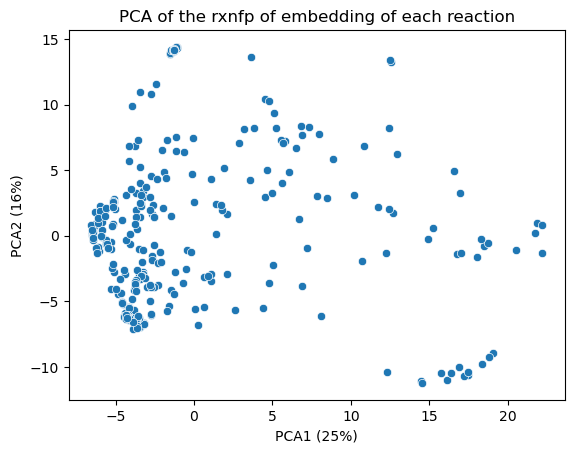

In [88]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X = np.array([x for x in rxn_embeddings_rxnfp['rxnfp'].values]).reshape((len(rxn_embeddings_rxnfp), len(rxn_embeddings_rxnfp['rxnfp'].values[0])))

pca_values = pca.fit_transform(X)
rxn_embeddings_rxnfp['PCA1'] = pca_values[:, 0]
rxn_embeddings_rxnfp['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(rxn_embeddings_rxnfp, x='PCA1', y='PCA2')
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the rxnfp of embedding of each reaction')

# Create ESM2 or ESM3 embeddings of each protein



In [89]:
# Do ESM embedding of the ones that look good!
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')
from enzymetk.embedprotein_esm_step import EmbedESM
from enzymetk.save_step import Save
import pandas as pd

df['id'] = [f'DEDBL{i}' for i in range(0, len(df))]
df = df[df['errors'].isna()]
# Fill in variants with parent if there is no variant
df['variant_aa'] = df['aa_sequence'].values
variant_df = df[~df['variant_aa'].isna()] 
variant_df = df[~df['variant_aa'].isna()] # Remove any that didn't have variants
variant_df = variant_df.drop_duplicates(subset=['variant_aa']) # Remove any that didn't have variants

variant_df['variant_id'] = [f'VDEDBL{i}' for i in range(0, len(variant_df))]
variant_df['variant_aa_nohis'] = [s.replace('LEHHHHHH', '').replace('HHHHHH', '').replace('*', '') for s in variant_df['variant_aa'].values]
# Save variant DF
variant_df.to_csv('output/protein-evolution-database_V5_proteins_reactions_clean_unique_variants_LLM.csv', index=False)

# Hmmm there are too many duplicates (need to check if this is from 
id_col = 'variant_id'
seq_col = 'variant_aa_nohis'

embedding_df = (variant_df << (EmbedESM(id_col, seq_col, extraction_method='mean') >> Save('output/protein-evolution-database_V5_embedded_proteins_LLM.pkl')))

--------------------------------------------------------------------------------
Running command	conda run -n enzymetk python /disk1/ariane/vscode/enzyme-tk/enzymetk/esm-extract.py esm2_t36_3B_UR50D /tmp/tmpzevdga_i/input.fasta /tmp/tmpzevdga_i --include per_tok	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------
Transferred model to GPU
Read /tmp/tmpzevdga_i/input.fasta with 831 sequences
Processing 1 of 73 batches (35 sequences)
Processing 2 of 73 batches (32 sequences)
Processing 3 of 73 batches (30 sequences)
Processing 4 of 73 batches (28 sequences)
Processing 5 of 73 batches (26 sequences)
Processing 6 of 73 batches (26 sequences)
Processing 7 of 73 batches (26 sequences)
Processing 8 of 73 batches (26 sequences

100%|████████████████████████████████████████████| 831/831 [00:00<00:00, 1143.00it/s]


0 0 0


In [90]:
embedding_df

,id,barcode_plate,plate,well,smiles_string,smiles_reaction,alignment_count,alignment_probability,nucleotide_mutation,amino_acid_substitutions,...,activity,parent_aa,errors,warnings,named_reactions,smiles_errors,variant_aa,variant_id,variant_aa_nohis,embedding
0,DEDBL0,1.0,Plate_1,A01,None,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>C(C1=CC=CC=...,1.0,1.0,NaN,#PARENT#,...,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None,None,"No cannonical substrate, None",MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,VDEDBL0,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,"[0.004967994, -0.041231778, 0.022678355, -0.02..."
1,DEDBL1,1.0,Plate_1,A02,None,ClCC(=O)N(C\C(=C\C1=CC=CC=C1)\C)C>>C(C1=CC=CC=...,1.0,1.0,G880T_A881G_T882G_A1028G_T1029G,D294W_Y343W,...,NaN,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,None,None,None,"No cannonical substrate, None",MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,VDEDBL1,MPSLFDPIRFGAFTAKNRIWMAPLTRGRATRDHVPTEIMAEYYAQR...,"[0.0070228814, -0.04200835, 0.022489596, -0.02..."
0,DEDBL9,1.0,Plate_1,A01,C=Cc1ccc(OC)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,COc1ccc(C=C)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,1.0,1.0,NaN,#PARENT#,...,NaN,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,None,None,1-ethenyl-4-methoxybenzene + ethyl 2-diazoacet...,None,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,VDEDBL2,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,"[-0.033582546, -0.06530124, -0.089957654, -0.0..."
1,DEDBL10,1.0,Plate_1,A02,C=Cc1ccc(OC)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,COc1ccc(C=C)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,1.0,1.0,NaN,W131F,...,NaN,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,None,None,1-ethenyl-4-methoxybenzene + ethyl 2-diazoacet...,None,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,VDEDBL3,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,"[-0.0310656, -0.066752486, -0.088299096, -0.02..."
2,DEDBL11,1.0,Plate_1,A03,C=Cc1ccc(OC)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,COc1ccc(C=C)cc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)C...,1.0,1.0,NaN,H131G,...,NaN,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,None,"[[H131G, Warning: position 0 and 1 index had s...",1-ethenyl-4-methoxybenzene + ethyl 2-diazoacet...,None,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,VDEDBL4,MTSSGVYTIAEVEAMTGLSAEVLRQWERRYGFPKPRRTPGGHRLYS...,"[-0.032231778, -0.06507881, -0.086370066, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,DEDBL2422,1.0,Plate_1,D04,Cc1cc[nH]n1>>Cc1ccn(C)n1.Cc1ccnn1C,Cc1cc[nH]n1>>Cn1ccc(C)n1.Cn1nccc1C,1.0,1.0,NaN,Y20F_D167H_D197M_S201S_N249A,...,NaN,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,None,"[[S201S, Warning: position 0 and 1 index had s...",5-methyl-1H-pyrazole =,None,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,VDEDBL826,MESGFTSKDTYLSHFNPRDFLEKYYKFGSRHSAESQILKHLLKNLF...,"[0.04039272, -0.0638588, 0.059366662, -0.12303..."
40,DEDBL2423,1.0,Plate_1,D05,Cc1cc[nH]n1>>Cc1ccn(C)n1.Cc1ccnn1C,Cc1cc[nH]n1>>Cn1ccc(C)n1.Cn1nccc1C,1.0,1.0,NaN,D167H_D197L_S201A_S213C_N249C,...,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-methyl-1H-pyrazole =,None,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,VDEDBL827,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,"[0.035802223, -0.065801434, 0.05715916, -0.126..."
42,DEDBL2424,1.0,Plate_1,D07,Cc1cc[nH]n1>>Cc1ccn(C)n1.Cc1ccnn1C,Cc1cc[nH]n1>>Cn1ccc(C)n1.Cn1nccc1C,1.0,1.0,NaN,Y20H_D167H_D197M_S201A_N249C,...,NaN,MESGFTSKDTYLSHFNPRDHLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-methyl-1H-pyrazole =,None,MESGFTSKDTYLSHFNPRDHLEKYYKFGSRHSAESQILKHLLKNLF...,VDEDBL828,MESGFTSKDTYLSHFNPRDHLEKYYKFGSRHSAESQILKHLLKNLF...,"[0.035601836, -0.06577594, 0.057052057, -0.125..."
44,DEDBL2425,1.0,Plate_1,D09,Cc1cc[nH]n1>>Cc1ccn(C)n1.Cc1ccnn1C,Cc1cc[nH]n1>>Cn1ccc(C)n1.Cn1nccc1C,1.0,1.0,NaN,D167H_D197M_S201C_Y204F_Y213H,...,NaN,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,None,None,5-methyl-1H-pyrazole =,None,MESGFTSKDTYLSHFNPRDYLEKYYKFGSRHSAESQILKHLLKNLF...,VDEDBL829,MESGFTSKDTYLSHFNPRDY

Text(0.5, 1.0, 'PCA of the ESM2')

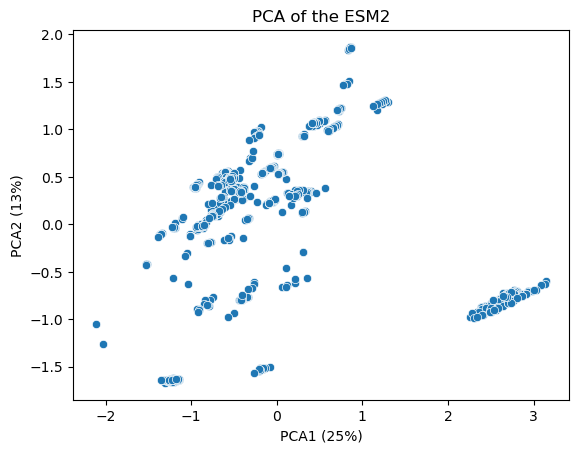

In [91]:
pca = PCA(n_components=2)
X = np.array([x for x in embedding_df['embedding'].values]).reshape((len(embedding_df), len(embedding_df['embedding'].values[0])))

pca_values = pca.fit_transform(X)
embedding_df['PCA1'] = pca_values[:, 0]
embedding_df['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(embedding_df, x='PCA1', y='PCA2')
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2')

# Save embedded file 

Save both only the parents and also the 

In [92]:
import pandas as pd
df.to_csv('output/protein-evolution-database_V5_proteins_reactions_clean.csv', index=False)
parents = df.drop_duplicates(subset=['parent_aa', 'reaction_smiles'])
parents['substrate_smiles'] = [x.split('>')[0] for x in parents['reaction_smiles'].values]
parents = parents[parents['aminoacid_mutations_from_parent'] == '?']
parents = parents.drop_duplicates(subset=['parent_aa', 'substrate_smiles'])
parents.to_csv('output/protein-evolution-database_DF5_proteins_reactions_clean_parents_LLM.csv', index=False)

KeyError: Index(['reaction_smiles'], dtype='object')

In [57]:
parents

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,SUBMITTED BY,raw data name,cannonical_reactions,named_reactions,errors,parent_aa,variant_aa,warnings,id,substrate_smiles
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,?,Asymmetric Carbene NH insertion 2021,CNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccccc1)[C...,3-diazooxolan-2-one + N-methylaniline =,None,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,DEDB0,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1
38,3560,P411BM3-CIS,?,pdb-4H23,O=C(OCC)C=[N+]=[N-].CN1C=CC2=C1C=CC=C2>>CN1C=C...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,?,?,...,Oliver Brandenberg,Indole Amination ACS Cat 2019,CCOC(=O)C=[N+]=[N-].Cn1ccc2ccccc21>>CCOC(=O)Cc...,ethyl 2-diazoacetate + 1-methylindole =,None,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,DEDB38,O=C(OCC)C=[N+]=[N-].CN1C=CC2=C1C=CC=C2
58,3560,P411BM3-CIS,?,pdb-4H23,O=C(C=[N+]=[N-])OCC.C12=C(CC=C2)C=CC=C1>>O=C(O...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,?,?,...,Oliver Brandenberg,Indole Amination ACS Cat 2019,C1=Cc2ccccc2C1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)[C...,ethyl 2-diazoacetate + 1H-indene =,None,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,DEDB58,O=C(C=[N+]=[N-])OCC.C12=C(CC=C2)C=CC=C1
61,3560,P411BM3-CIS,?,pdb-4H23,O=C(C=[N+]=[N-])OCC.C1=CC=CCC1>>O=C(OCC)[C@H]1...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,?,?,...,Oliver Brandenberg,Indole Amination ACS Cat 2019,C1=CCCC=C1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)[C@@H]...,"ethyl 2-diazoacetate + cyclohexa-1,3-diene =",None,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,DEDB61,O=C(C=[N+]=[N-])OCC.C1=CC=CCC1
76,4866,P411-C10,?,?,CCC#CC1=CC=CC=C1.O=C(OCC)C=[N+]=[N-]>>[H][C@]2...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,Kai Chen,Internal cyclopropene 2020,CCC#Cc1ccccc1.CCOC(=O)C=[N+]=[N-]>>CCOC(=O)[C@...,but-1-ynylbenzene + ethyl 2-diazoacetate =,None,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,DEDB76,CCC#CC1=CC=CC=C1.O=C(OCC)C=[N+]=[N-]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,4859,E. coli taurine dioxygenase,P37610,?,C=CC1=CC=CC=C1.O=S(C1=CC=C(C)C=C1)(N=[N+]=[N-]...,ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCG...,?,?,ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCG...,?,...,Nathaniel W. Goldberg,NaN,C=Cc1ccccc1.Cc1ccc(S(=O)(=O)N=[N+]=[N-])cc1>>C...,styrene + N-diazo-4-methylbenzenesulfonamide =,None,MSERLSITPLGPYIGAQISGADLTRPLSDNQFEQLYHAVLRHQVVF...,MSERLSITPLGPYIGAQISGADLTRPLSDNQFEQLYHAVLRHQVVF...,None,DEDB1287,C=CC1=CC=CC=C1.O=S(C1=CC=C(C)C=C1)(N=[N+]=[N-])=O
1288,4860,A. thaliana Anthocyanidin synthase,Q96323,?,C=CC1=CC=CC=C1.O=S(C1=CC=C(C)C=C1)(N=[N+]=[N-]...,ATGGTCGCGGTAGAGCGCGTTGAATCCTTAGCGAAGAGCGGAATCA...,?,?,ATGGTCGCGGTAGAGCGCGTTGAATCCTTAGCGAAGAGCGGAATCA...,?,...,Nathaniel W. Goldberg,NaN,C=Cc1ccccc1.Cc1ccc(S(=O)(=O)N=[N+]=[N-])cc1>>C...,styrene + N-diazo-4-methylbenzenesulfonamide =,None,MVAVERVESLAKSGIISIPKEYIRPKEELESINDVFLEEKKEDGPQ...,MVAVERVESLAKSGIISIPKEYIRPKEELESINDVFLEEKKEDGPQ...,None,DEDB1288,C=CC1=CC=CC=C1.O=S(C1=CC=C(C)C=C1)(N=[N+]=[N-])=O
1289,4861,Streptomyces sp. 2-aminobutyric acid chlorinase,D0VX22,?,C=CC1=CC=CC=C1.O=S(C1=CC=C

In [93]:
df.to_csv('output/protein-evolution-database_V5_proteins_reactions_clean_LLM.csv', index=False)
